<h1>Preprocessing</h1>
The Dataset are made in this way:
<ul>
    <li>objid       = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS</li>
    <li>ra          = Right Ascension angle (at J2000 epoch)</li>
    <li>dec         = Declination angle (at J2000 epoch)</li>
    <li>u           = Ultraviolet filter in the photometric system</li>
    <li>g           = Green filter in the photometric system</li>
    <li>r           = Red filter in the photometric system</li>
    <li>i           = Near Infrared filter in the photometric system</li>
    <li>z           = Infrared filter in the photometric system</li>
    <li>run         = Run Number used to identify the specific scan</li>
    <li>rereun      = Rerun Number to specify how the image was processed</li>
    <li>camcol      = Camera column to identify the scanline within the run</li>
    <li>field       = Field number to identify each field</li>
    <li>specobjid   = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)</li>
    <li>redshift    = redshift value based on the increase in wavelength</li>
    <li>plate       = plate ID, identifies each plate in SDSS</li>
    <li>mjd         = Modified Julian Date, used to indicate when a given piece of SDSS data was taken</li>
    <li>fiberid     = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation</li>
    <li>class       = object class (galaxy, star or quasar object)</li>
</ul>

In [48]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import confusion_matrix

Let's start loading the dataset in a dataframe

In [49]:
# dfStars = pd.read_csv('Skyserver_12_15_2020 3 45 07 AM.csv', na_values="?")
dfStars = pd.read_csv('FileCSV/star_classification.csv', na_values="?")
dfStars

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [3]:
dfStars.head().T

,0,1,2,3,4
objid,1237660961327743232.0,1237664879951151104.0,1237660961330430208.0,1237663478724297984.0,1237680272041378048.0
ra,135.689107,144.826101,142.18879,338.741038,345.282593
dec,32.494632,31.274185,35.582444,-0.402828,21.183866
u,23.87882,24.77759,25.26307,22.13682,19.43718
g,22.2753,22.83188,22.66389,23.77656,17.58028
r,20.39501,22.58444,20.60976,21.61162,16.49747
i,19.16573,21.16812,19.34857,20.50454,15.97711
z,18.79371,21.61427,18.94827,19.2501,15.54461
run,3606,4518,3606,4192,8102
rerun,301,301,301,301,301


Here I check the distribution of the Labeled-Class

In [4]:
dfStars['class'].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

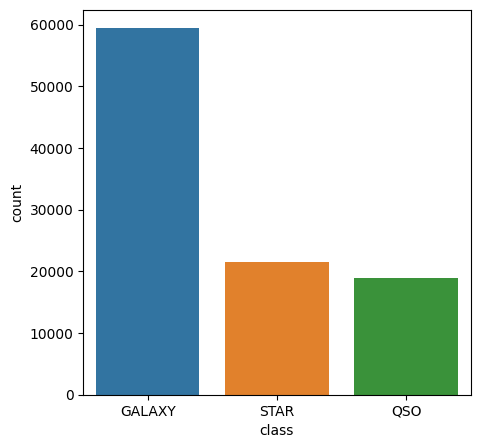

In [5]:
fig,axes = plt.subplots(1, 1, figsize=(5,5), sharey=True)
sns.countplot(x='class',data = dfStars, ax = axes, order = dfStars['class'].value_counts().index)
plt.show()

Check same info about the feature of the DataSet

In [6]:
dfStars.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [7]:
dfStars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  float64
 1   ra         100000 non-null  float64
 2   dec        100000 non-null  float64
 3   u          100000 non-null  float64
 4   g          100000 non-null  float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          100000 non-null  float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      100000 non-null  int64  
 12  specobjid  100000 non-null  float64
 13  class      100000 non-null  object 
 14  redshift   100000 non-null  float64
 15  plate      100000 non-null  int64  
 16  mjd        100000 non-null  int64  
 17  fiberid    100000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 13.7+ MB


Check for Nan or Null value

In [8]:
dfStars.isna().sum(axis=0)

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

Checking if there is some duplicate

In [9]:
dfStars[dfStars.duplicated(keep=False)]

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid


<h1>Normalization of the classed-class</h1>



In [50]:
# Normalize the classed-class with numerical data
dfStarsNormalize = dfStars
dfStarsNormalize['class'] = dfStarsNormalize['class'].replace({'GALAXY': 0, 'STAR': 1, 'QSO': 2})

<h1>Split the dataset in training set and test set.</h1>

In [51]:
# Split the dataset into features and classs
X = dfStarsNormalize.drop('class', axis=1)
y = dfStarsNormalize['class']
X.shape, y.shape

((100000, 17), (100000,))

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)
print('Shape of the train and test set')
print(X_train.shape) # type: ignore
print(X_test.shape) # type: ignore
print()
print('Distribution of the labeled-classes')  
print()
print("Training Set")
print(pd.Series(y_train).value_counts())
print()
print("Test Set")
print(pd.Series(y_test).value_counts())

Shape of the train and test set
(70000, 17)
(30000, 17)

Distribution of the labeled-classes

Training Set
0    41636
1    15044
2    13320
Name: class, dtype: int64

Test Set
0    17809
1     6550
2     5641
Name: class, dtype: int64


<h1>Feature Selection</h1>

In the following cell I perform SelectKBest wit f_regression with k=10, for select the best feature

In [68]:
# Create an object SelectKBest with the value of k
selector = SelectKBest(score_func=f_regression, k=10)

# Fit
X_selected = selector.fit_transform(X_train, y_train)

dfKBest = pd.DataFrame(selector.scores_, columns=['Score'])
dfKBest.index = ['objid','ra','dec','u','g','r','i','z','run','rerun','camcol','field','specobjid','redshift','plate','mjd','fiberid'] # type: ignore
display(dfKBest.sort_values(by='Score', ascending=False))
print()
print("Features selected:")
print(X_train.columns[selector.get_support()]) # type: ignore

,Score
redshift,28655.952271
z,9269.757834
i,6208.254359
u,3823.399010
plate,3402.130505
specobjid,3402.116179
mjd,3109.637519
r,1659.220666
g,305.125852
dec,218.452539



Features selected:
Index(['dec', 'u', 'g', 'r', 'i', 'z', 'specobjid', 'redshift', 'plate',
       'mjd'],
      dtype='object')


<h3>Delete Features</h3>
Drop all features rated lower than 10

In [18]:
X_train.drop(['objid', 'ra', 'run','rerun','camcol','field','fiberid'], axis = 1, inplace=True) # type: ignore

<h1>Rebalance Dataset</h1>
I add features into the two minority classes (STAR, QSO) until they reach the class with the higer number of examble (GALAXY). <br>
In the following snip of code I implement an over sampling without replacement, using SMOTE.

In [19]:
# using oversampling with SMOTE to deal with imbalanced data
sm = SMOTE(random_state=42)
X_train_after_balancing, y_train_after_balancing = sm.fit_resample(X_train, y_train) # type: ignore

print(X_train_after_balancing.shape) # type: ignore
y_train_after_balancing.value_counts() # type: ignore

(124908, 10)


0    41636
1    41636
2    41636
Name: class, dtype: int64

<h1 style="font-weight: bold">CLASSIFICATION</h1>

In [33]:
X_test_drop = X_test.drop(['objid', 'ra', 'run', 'rerun', 'camcol', 'field', 'fiberid'], axis = 1) # type: ignore

<h2>KNeighborsClassifier</h2>
I tried to perform KNN with different k, for understand which is the best. <br>
I decided to use the euclidean and the manhattan distance, for make a comparison

In [25]:
k_neighbors = 100
metrics = ['euclidean', 'manhattan']

accuracy_total = []
for k in range(1, k_neighbors+1, 1):
    accuracy_k = []
    for metric in metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_after_balancing, y_train_after_balancing)
        y_predKNN = knn.predict(X_test_drop)
        accuracy = accuracy_score(y_test, y_predKNN)
        accuracy_k.append(accuracy)
        # print(f"For metric = {metric} and k = {k}:      ACCURACY = {accuracy}")
    accuracy_total.append(accuracy_k)

accuracy_df = pd.DataFrame(np.array(accuracy_total), columns=metrics)
k_df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100], columns=['k'])
accuracy_join= k_df.join(accuracy_df)

The following snip of code shows us the trend of the KNN's accuracy for the euclidean and manhattan distance.<br> 
The graph for each distance it's almost the same. But the accurasy reach just the 67% in the peak, for k = 3.

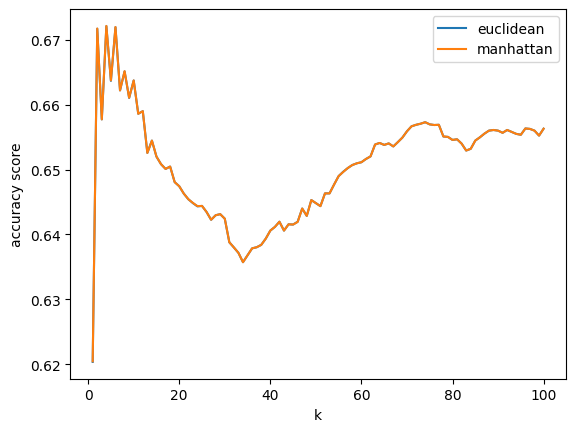

In [26]:
plt.plot(accuracy_join['k'], accuracy_join['euclidean'], label='euclidean')
plt.plot(accuracy_join['k'], accuracy_join['manhattan'], label='manhattan')

plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy score')
plt.show()

In [27]:
accuracy_ed = []
accuracy_md = []

for i in range(k_neighbors):
    accuracy_ed.append(accuracy_total[i][0])
    accuracy_md.append(accuracy_total[i][1])

max_index = max(enumerate(accuracy_ed), key=lambda x: x[1])[0]
print(f"Euclidean Distance: The value of k with the higher accuracy is {max_index}. Accurasy = {accuracy_ed[max_index]}")

max_index = max(enumerate(accuracy_md), key=lambda x: x[1])[0]
print(f"Manhattan Distance: The value of k with the higher accuracy is: {max_index}. Accurasy = {accuracy_md[max_index]}")

accuracyKNN = accuracy_md[max_index]

Euclidean Distance: The value of k with the higher accuracy is 3. Accurasy = 0.6721
Manhattan Distance: The value of k with the higher accuracy is: 3. Accurasy = 0.6721333333333334


<h2>Decision Tree</h2>

In [28]:
# Create the model
rf = DecisionTreeClassifier()

# Fit the model
rf = rf.fit(X_train_after_balancing, y_train_after_balancing)
y_predDT = rf.predict(X_test_drop)

# Check the accuracy
accuracyDT = accuracy_score(y_test, y_predDT)
print(f"Accuracy: {accuracyDT:.2f}")

# Check the performance
scores = cross_val_score(rf, X_train_after_balancing, y_train_after_balancing, cv=10)
print(f"Performances: {scores}")
print(f"Average performance: {scores.mean():.2f}")



Accuracy: 0.96
Performances: [0.96657593 0.97045873 0.97598271 0.9761819  0.9752612 ]
Average performance: 0.97


<h1>Random Forest</h1>

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create the model
rf = RandomForestClassifier(criterion="entropy")

# Fit the model
rf.fit(X_train_after_balancing, y_train_after_balancing)

# Check the accuracy
y_predRF = rf.predict(X_test_drop)
accuracyRF = accuracy_score(y_test, y_predRF)
print(f"Accuracy: {accuracyRF:.2f}")

Accuracy: 0.98


<h2>Bayesian Classifier</h2>

In [34]:
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr

# Create the model
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train_after_balancing, y_train_after_balancing)

# Check the accuracy
y_predBC = gnb.predict(X_test_drop)
accuracyBC = accuracy_score(y_test, y_predBC)
print(f"Accuracy: {accuracyBC:.2f}")

Accuracy: 0.30


<h3>ACCURACY</h3>
Now we will analize the accuracy of all the tried classifier.<br>
We can note that the best algorithm is Random Forest


In [35]:
print(f"Accuracy of Random Forest: {accuracyRF:.2f}")
print(f"Accuracy of Decision Tree: {accuracyDT:.2f}")
print(f"Accuracy of KNN: {accuracyKNN:.2f}")
print(f"Accuracy of Bayesian Classifier: {accuracyBC:.2f}")

Accuracy of Random Forest: 0.98
Accuracy of Decision Tree: 0.96
Accuracy of KNN: 0.67
Accuracy of Bayesian Classifier: 0.30


<h1>Evaluation of the model</h1>

Cross-Validation for Random Forest

Cross-validation scores: [0.97726363 0.97838444 0.97950524 0.98518934 0.98831158 0.98526939
 0.98655032 0.98655032 0.98694956 0.98638911]
Mean score: 0.9840362928402124


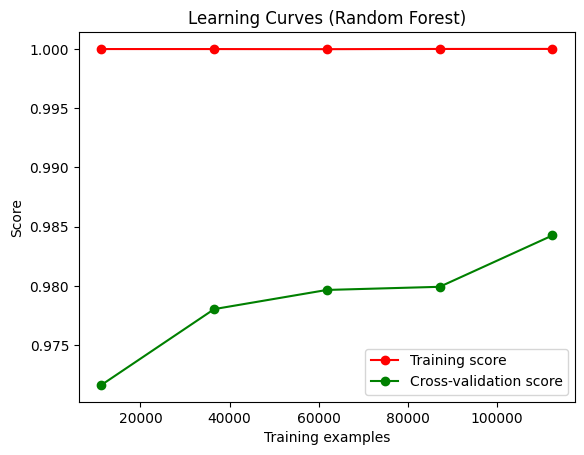

In [30]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt

# Utilizza la cross-validation per valutare l'accuratezza del modello
scores = cross_val_score(rf, X_train_after_balancing, y_train_after_balancing, cv=10)

# Stampa i risultati della cross-validation
print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())

# Disegna la curva di apprendimento del modello
train_sizes, train_scores, test_scores = learning_curve(rf, X_train_after_balancing, y_train_after_balancing, cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label="Cross-validation score")

plt.title("Learning Curves (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Here I compute the Confusion Matrix for the Random Forest algorithm


In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_predRF)
dfConMat = pd.DataFrame()
dfConMat['GALAXY'] = [confusion_matrix[0, 0], confusion_matrix[1, 0], confusion_matrix[2, 0], confusion_matrix[:, 0].sum()]
dfConMat['STAR'] = [confusion_matrix[0, 1], confusion_matrix[1, 1], confusion_matrix[2, 1], confusion_matrix[:, 1].sum()]
dfConMat['QUASAR'] = [confusion_matrix[0, 2], confusion_matrix[1, 2], confusion_matrix[2, 2], confusion_matrix[:, 2].sum()]
dfConMat['TOT'] = [confusion_matrix[0, :].sum(), confusion_matrix[1, :].sum(), confusion_matrix[2, :].sum(), confusion_matrix.sum()]
dfConMat.index = ['GALAXY', 'STAR', 'QUASAR', 'TOT'] # type: ignore
dfConMat


,GALAXY,STAR,QUASAR,TOT
GALAXY,17439,32,338,17809
STAR,4,6546,0,6550
QUASAR,301,1,5339,5641
TOT,17744,6579,5677,30000


Compute **Accuracy**, **Sensitivity**, **Specificity**, **Precision** and **Recall** form the Confusion Matrix

In [39]:
# Estraiamo gli elementi della confusion matrix che ci serviranno per calcolare le metriche
tp0, tp1, tp2 = confusion_matrix[0, 0], confusion_matrix[1, 1], confusion_matrix[2, 2]
fn0, fn1, fn2 = confusion_matrix[0, 1] + confusion_matrix[0, 2], confusion_matrix[1, 0] + confusion_matrix[1, 2], confusion_matrix[2, 0] + confusion_matrix[2, 1]
fp0, fp1, fp2 = confusion_matrix[1, 0] + confusion_matrix[2, 0], confusion_matrix[0, 1] + confusion_matrix[2, 1], confusion_matrix[0, 2] + confusion_matrix[1, 2]
tn0 = confusion_matrix[1, 1] + confusion_matrix[1, 2] + confusion_matrix[2, 1] + confusion_matrix[2, 2]
tn1 = confusion_matrix[0, 0] + confusion_matrix[0, 2] + confusion_matrix[2, 0] + confusion_matrix[2, 2]
tn2 = confusion_matrix[0, 0] + confusion_matrix[0, 1] + confusion_matrix[1, 0] + confusion_matrix[1, 1]

# Calcoliamo le metriche
accuracy0 = (tp0 + tn0)/confusion_matrix.sum()
accuracy1 = (tp1 + tn1)/confusion_matrix.sum()
accuracy2 = (tp2 + tn2)/confusion_matrix.sum()
sensitivity0 = tp0 / (tp0 + fn0)
sensitivity1 = tp1 / (tp1 + fn1)
sensitivity2 = tp2 / (tp2 + fn2)
specificity0 = tn0 / (tn0 + fp0)
specificity1 = tn1 / (tn1 + fp1)
specificity2 = tn2 / (tn2 + fp2)
precision0 = tp0 / (tp0 + fp0)
precision1 = tp1 / (tp1 + fp1)
precision2 = tp2 / (tp2 + fp2)
recall0 = tp0 / (tp0 + fn0)
recall1 = tp1 / (tp1 + fn1)
recall2 = tp2 / (tp2 + fn2)
fMeasure0 = (2*recall0*precision0)/(recall0+precision0)
fMeasure1 = (2*recall1*precision1)/(recall1+precision1)
fMeasure2 = (2*recall2*precision2)/(recall2+precision2)


print(f"Accuracy (GALAXY): {accuracy0:.2f}")
print(f"Accuracy (STAR): {accuracy1:.2f}")
print(f"Accuracy (QUASAR): {accuracy2:.2f}")
print()
print(f"Sensitivity (GALAXY): {sensitivity0:.2f}")
print(f"Sensitivity (STAR): {sensitivity1:.2f}")
print(f"Sensitivity (QUASAR): {sensitivity2:.2f}")
print()
print(f"Specificity (GALAXY): {specificity0:.2f}")
print(f"Specificity (STAR): {specificity1:.2f}")
print(f"Specificity (QUASAR): {specificity2:.2f}")
print()
print(f"Precision (GALAXY): {precision0:.2f}")
print(f"Precision (STAR): {precision1:.2f}")
print(f"Precision (QUASAR): {precision2:.2f}")
print()
print(f"Recall (GALAXY): {recall0:.2f}")
print(f"Recall (STAR): {recall1:.2f}")
print(f"Recall (QUASAR): {recall2:.2f}")
print()
print(f"F Measure (GALAXY): {fMeasure0:.2f}")
print(f"F Measure (STAR): {fMeasure1:.2f}")
print(f"F Measure (QUASAR): {fMeasure2:.2f}")

Accuracy (GALAXY): 0.98
Accuracy (STAR): 1.00
Accuracy (QUASAR): 0.98

Sensitivity (GALAXY): 0.98
Sensitivity (STAR): 1.00
Sensitivity (QUASAR): 0.95

Specificity (GALAXY): 0.97
Specificity (STAR): 1.00
Specificity (QUASAR): 0.99

Precision (GALAXY): 0.98
Precision (STAR): 0.99
Precision (QUASAR): 0.94

Recall (GALAXY): 0.98
Recall (STAR): 1.00
Recall (QUASAR): 0.95

F Measure (GALAXY): 0.98
F Measure (STAR): 1.00
F Measure (QUASAR): 0.94


<h1 style="font-weight: bold">Save The Model<h1>

<p style="size: 12pt">I'll save the model of Random Forest in a file, for using them in an external application</p>

In [69]:
with open('starClassificationApp/model.pkl', 'wb') as f:
    pickle.dump(rf, f)

NameError: name 'rf' is not defined